<a href="https://colab.research.google.com/github/bfdefraga/Analise-da-Logistica-de-Distribuicao-da-Loggi/blob/main/Analise_da_Logistica_de_Distribuicao_da_Loggi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ANÁLISE DA LOGÍSTICA DE DISTRIBUIÇÃO DA LOGGI**

# 1. Contextualização

Nos serviços de entregas de encomendas, uma questão logística vital é a localização dos centros de distribuição (*hubs*) e suas áreas de entrega correspondentes.

Ao considerar essa questão, analisou-se a estrutura de hubs da empresa **Loggi** no Distrito Federal a fim de caracterizar o panorama atual e, se necessário, sugerir otimizações.

Para isso, informações referentes às entregas, às localizações dos hubs e à capacidade de armazenamento dos veículos foram utilizadas.

A partir da análise realizada, observou-se uma necessária readequação da logística de distribuição das áreas dos hubs e da frota de transporte dos pedidos.

Ressalta-se que dois hubs vizinhos apresentam grandes diferenças na porcentagem da quantidade de entregas e na distância das áreas de entregas, o que requer uma abordagem conjunta da equipe de logística e ou transporte e financeira para otimizar a estrutura e os custos da distribuição atual.  

No item 4.2, podemos verificar diretamente as imagens, os gráficos e os insights pertinentes. E, no item 5, podemos analisar a conclusão dos insights gerados.

# 2. Pacotes e Bibliotecas


In [ ]:
# Nativos

import json

# Terceiros

import geopandas
import geopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# 3. Dados

### 3.1 Coleta dos Dados

In [ ]:
# Coleta dos dados em formato JSON da Loggi Benchmark for Urban Deliveries (BUD) project.

!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

In [ ]:
# Utilização do API Nominatim a fim de gerar processo de geocodificação.

geolocator = Nominatim(user_agent="ebac_geocoder")

# Extração dos dados textuais de endereço com a função de geolocalização reversa.

geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [ ]:
# Coleta dos dados de geocodificação.

!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

In [ ]:
# Coleta e processamento dos mapas do Distrito Federal.

!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

### 3.2 Extração dos Dados

Na etapa inicial de manipulação dos dados, processou-se o arquivo em formato JSON para gerar o DataFrame original. Nesse arquivo, consta uma lista de instâncias, onde cada instância representa um conjunto de entregas que devem ser realizadas pelos veículos do hub regional a que pertencem.

Para melhor compreensão de como os dados estão estruturados inicialmente, segue um exemplo com as informações referentes a cada entrega.

```json
[
  {
    "name": "cvrp-0-df-0",
    "region": "df-0",
    "origin": {"lng": -47.802664728268745, "lat": -15.657013854445248},
    "vehicle_capacity": 180,
    "deliveries": [
      {
        "id": "ed0993f8cc70d998342f38ee827176dc",
        "point": {"lng": -47.7496622016347, "lat": -15.65879313293694},
        "size": 10
      },
      {
        "id": "c7220154adc7a3def8f0b2b8a42677a9",
        "point": {"lng": -47.75887552060412, "lat": -15.651440380492554},
        "size": 10
      },
      ...
    ]
  }
]
...


Onde:

 - **name**: uma `string` com o nome único da instância;
 - **region**: uma `string` com o nome único da região do **hub**;
 - **origin**: um `dict` com a latitude e longitude da região do **hub**;
 - **vehicle_capacity**: um `int` com a soma da capacidade de carga dos **veículos** do **hub**;
 - **deliveries**: uma `list` de `dict` com as **entregas** que devem ser realizadas.

In [ ]:
# Arquivo JSON alocado em uma variável.

with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

In [ ]:
# Verificação do tamanho da lista de instâncias do arquivo JSON.

len(data)

199

In [ ]:
# Criação do DataFrame original referente aos dados brutos.

deliveries_df = pd.DataFrame(data)
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


In [ ]:
# Informações gerais do DataFrame original.

deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              199 non-null    object
 1   region            199 non-null    object
 2   origin            199 non-null    object
 3   vehicle_capacity  199 non-null    int64 
 4   deliveries        199 non-null    object
dtypes: int64(1), object(4)
memory usage: 7.9+ KB


In [ ]:
# Conferência do tamanho do DataFrame original.
len(deliveries_df)

199

### 3.3 Limpeza e Processamento dos Dados

In [ ]:
# Criação de novo DataFrame com a coluna "origin" aplicando método de normalização.

hub_origin_df = pd.json_normalize(deliveries_df["origin"])

In [ ]:
# visualização das duas novas colunas referentes à latitude e à longitude dos hubs de origem das entregas.
hub_origin_df.head()

,lng,lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145
3,-47.893662,-15.805118
4,-48.054989,-15.838145


In [ ]:
# Junção do DataFrame original com o DataFrame referente às coordenadas dos hubs de entrega.

deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)

In [ ]:
# Processamento dos dados para melhor visualização.

deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)

deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


In [ ]:
# Criação do DataFrame com método de explosão para gerar uma linha para cada elemento (entrega) da lista de entregas.

deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")

In [ ]:
# Criação do DataFrame a partir dos elementos da coluna "deliveries" com estrutura de concatenação para preservar os índices.

deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)



In [ ]:
deliveries_normalized_df.head()

,delivery_size,delivery_lng,delivery_lat
0,9,-48.116189,-15.848929
0,2,-48.118195,-15.850772
0,1,-48.112483,-15.847871
0,2,-48.118023,-15.846471
0,7,-48.114898,-15.858055


**NOTA**

Lembrando que cada entrega (uma instância) possui uma lista de entregas (vários dicionários) que serão feitas pelo mesmo hub da região. Isto é, os índices 0, 1 e 2 referem-se aos três hubs de entrega e suas respectivas regiões de entrega.

Na amostra acima, vemos algumas entregas relizadas a partir do hub da região 0. A fim de preservar esses índices, utilizou-se o método "pd.concat()" ao invés do método "pd.jason_normalize()".

Caso contrário, esses índices não seriam mantidos e se perderia a referência dos hubs logísticos ocasionando inconsistência dos dados.

In [ ]:
# Verificação do tamanho do DataFrame de normalização, em que cada elemento é uma entrega.

len(deliveries_normalized_df)

636149

In [ ]:
# Integração ao DataFrame original.

deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


In [ ]:
# Avaliação do tamanho do DataFrame original após processamento.

len(deliveries_df)

636149

### 3.4 Exploração dos Dados

In [ ]:
# Conferência do número de linhas e colunas do DataFrame após primeira etapa de processamento.

deliveries_df.shape

(636149, 8)

In [ ]:
# Verificação do nome das colunas.


deliveries_df.columns

Index(['name', 'region', 'hub_lng', 'hub_lat', 'vehicle_capacity',
       'delivery_size', 'delivery_lng', 'delivery_lat'],
      dtype='object')

In [ ]:
# Avaliação do 'range' para acessar e manipular os dados.

deliveries_df.index

RangeIndex(start=0, stop=636149, step=1)

In [ ]:
# Retorno das informações gerais do DataFrame.

deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


In [ ]:
deliveries_df.head(n=5)

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


In [ ]:
# Verificação dos tipos de dados contidos em cada coluna.

deliveries_df.dtypes

,0
name,object
region,object
hub_lng,float64
hub_lat,float64
vehicle_capacity,int64
delivery_size,int64
delivery_lng,float64
delivery_lat,float64


In [ ]:
# Verificação dos atributos categóricos. Notar valor 199 apontando consistência dos dados, haja vista DataFrame original ter 199 ID's.

deliveries_df.select_dtypes("object").describe().transpose()

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708


In [ ]:
# Verificação dos atributos numéricos. Notar que todos os centros têm veículos com a mesma capacidade.

deliveries_df.drop(["name", "region"], axis=1).select_dtypes('int64').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


In [ ]:
# Verificação de dados faltantes ou nulos.

deliveries_df.isna().any()

,0
name,False
region,False
hub_lng,False
hub_lat,False
vehicle_capacity,False
delivery_size,False
delivery_lng,False
delivery_lat,False


### 3.5 Enriquecimento e Qualidade dos Dados

In [ ]:
# Exclusão de valores duplicados em colunas de interesse.

hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


In [ ]:
# Verificação de uma amostra dos dados utilizando API Nominatim.

location = geolocator.reverse("-15.657013854445248, -47.802664728268745")
print(json.dumps(location.raw, indent=2, ensure_ascii=False))

{
  "place_id": 14416233,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright",
  "osm_type": "way",
  "osm_id": 240210480,
  "lat": "-15.656916027876347",
  "lon": "-47.80264463632131",
  "class": "highway",
  "type": "secondary",
  "place_rank": 26,
  "importance": 0.053411383993285995,
  "addresstype": "road",
  "name": "Rua 7",
  "display_name": "Rua 7, Quadra 2, Vila DNOCS, Sobradinho, Região Geográfica Imediata do Distrito Federal, Região Integrada de Desenvolvimento do Distrito Federal e Entorno, Região Geográfica Intermediária do Distrito Federal, Distrito Federal, Região Centro-Oeste, 73015-202, Brasil",
  "address": {
    "road": "Rua 7",
    "residential": "Quadra 2",
    "suburb": "Vila DNOCS",
    "town": "Sobradinho",
    "municipality": "Região Geográfica Imediata do Distrito Federal",
    "county": "Região Integrada de Desenvolvimento do Distrito Federal e Entorno",
    "state_district": "Região Geográfica Intermediária do Distrito Federa

In [ ]:
 # Extração dos dados de endereço com a função de geolocalização reversa.

geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [ ]:
# Criação de nova coluna contendo informações textuais do endereço a partir do 'geocoder'.

hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Vila DNOCS, Sobradinho, Regi..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Setor B S..."


In [ ]:
# Processamento dos geodados a partir de um novo DataFrame.

hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number,address.quarter
0,14416233,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.053411,...,BR-DF,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN,NaN
1,14619249,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172753950067,-47.89372354453109,highway,residential,26,0.053411,...,BR-DF,Região Centro-Oeste,70336-000,Brasil,br,SQS 303,Brasília,NaN,NaN,NaN
2,11654896,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.000051,...,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8,Setor B Sul


In [ ]:
# Adição de dados faltantes a partir de colunas com informações comuns.

hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

,hub_suburb,hub_city
0,Vila DNOCS,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga Centro,Taguatinga


O DataFrame hub_geodata_df com as informações de cidade e bairro é então combinado ao DataFrame principal deliveries_df, enriquecendo assim o dado.

**Notar:** o **índice 0** corresponde ao hub de **Sobradinho**, já o **índice 1** corresponde ao hub de **Brasília** e, por sua vez, o **índice 2** corresponde ao hub de **Taguatinga**.

In [ ]:
# Junção dos DataFrames com geodados.

hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Vila DNOCS,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga Centro,Taguatinga


**IMPORTANTE**

Como abordado previamente, o Distrito Federal é dividido em trés regiões conforme o hub correspondente: o índice 0 (**df-0**) corresponde a **Sobradinho**; o índice 1 (**df-1**) correponde à **Brasília**; e o índice 2 (**df-2**) corresponde à **Taguatinga**.

In [ ]:
# Adição das novas informações ao DataFrame original.

deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,7,-48.114898,-15.858055


**Geocodificação Reversa de Entrega**

Em razão do servidor Nominatim apresentar limitações de consulta para grandes volumes de dados, nessa análise foram utilizados os dados já processados em um arquivo do tipo .csv a fim de facilitar o tratamento dos dados.

In [ ]:
# Criação de novo DataFrame com as informações geocidificadas das entregas.

deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [ ]:
# Junção ao DataFrame original.
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


### 3.6 Verificação da Qualidade dos Dados

In [ ]:
# Verificação das informações gerais do DataFrame original processado até essa etapa.

deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 58.2+ MB


In [ ]:
# Verificação de valores nulos.

deliveries_df.isna().any()

,0
name,False
region,False
hub_lng,False
hub_lat,False
hub_city,False
hub_suburb,False
vehicle_capacity,False
delivery_size,False
delivery_lng,False
delivery_lat,False


In [ ]:
# Porcentagem de valores nulos na coluna 'delivery_city'.

100 * (deliveries_df["delivery_city"].isna().sum() / len(deliveries_df))

np.float64(0.26754738276724477)

In [ ]:
# Porcentagem de valores nulos na coluna 'delivery_suburb'.

100 * (deliveries_df["delivery_suburb"].isna().sum() / len(deliveries_df))

np.float64(25.133262804783158)

In [ ]:
# Ordenação das cidades em relação ao percentual de valores nulos para coluna 'delivery_city'.

prop_df = deliveries_df[["delivery_city"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

,count
delivery_city,
Brasília,0.234195
Taguatinga,0.071625
Sudoeste / Octogonal,0.069504
Ceilândia,0.059661
Águas Claras,0.058293
Guará,0.055619
Lago Sul,0.045620
Sobradinho,0.045412
Lago Norte,0.040832


In [ ]:
# Ordenação das cidades em relação ao percentual de valores nulos para coluna 'delivery_suburb'.

prop_df = deliveries_df[["delivery_suburb"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

,count
delivery_suburb,
Brasília,0.084564
Asa Norte,0.076639
Taguatinga,0.063363
Asa Sul,0.059263
Águas Claras,0.056598
Guará,0.055619
Samambaia,0.026514
Sobradinho,0.018148
Recanto das Emas,0.015029


**Nota**: identifica-se que a cidade de Brasília é responsável pelas maiores porcentagens de dados nulos, isso decorre da cidade não apresentar divisões administrativas por bairros, mas sim por regiões. Por isso, obervamos que a cidade de Brasília é contada como bairro.

# 4. Análise e Visualização dos Dados

## 4.1 Etapa de Preparação dos Dados

Mapa do Distrito Federal

In [ ]:
# Criação de um GeoDataFrame a partir dos mapas do Distrito Federal.

mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]  # a primeira linha ([0]) corresponde ao Distrito Federal.
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0, -47.31057 -..."


**Mapa dos Hubs**

In [ ]:
# Recriação do DataFrame "hub_df"

hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)

# Criação do GeoDataFrame para Mapas dos Hubs.

geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


**Mapa das entregas**

O DataFrame geo_deliveries_df é criado através do DataFrame deliveries_df. Note a nova coluna geometry.

In [ ]:
# Criação de outro GeoDataFrame a partir da junção do DataFrame original, notar coluna 'geometry'.

geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga Centro,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.1149 -15.85805)


## 4.2 Geração Visual dos Dados


### 4.2.1 Mapas da Distibuição das Entregas por Região e Hub

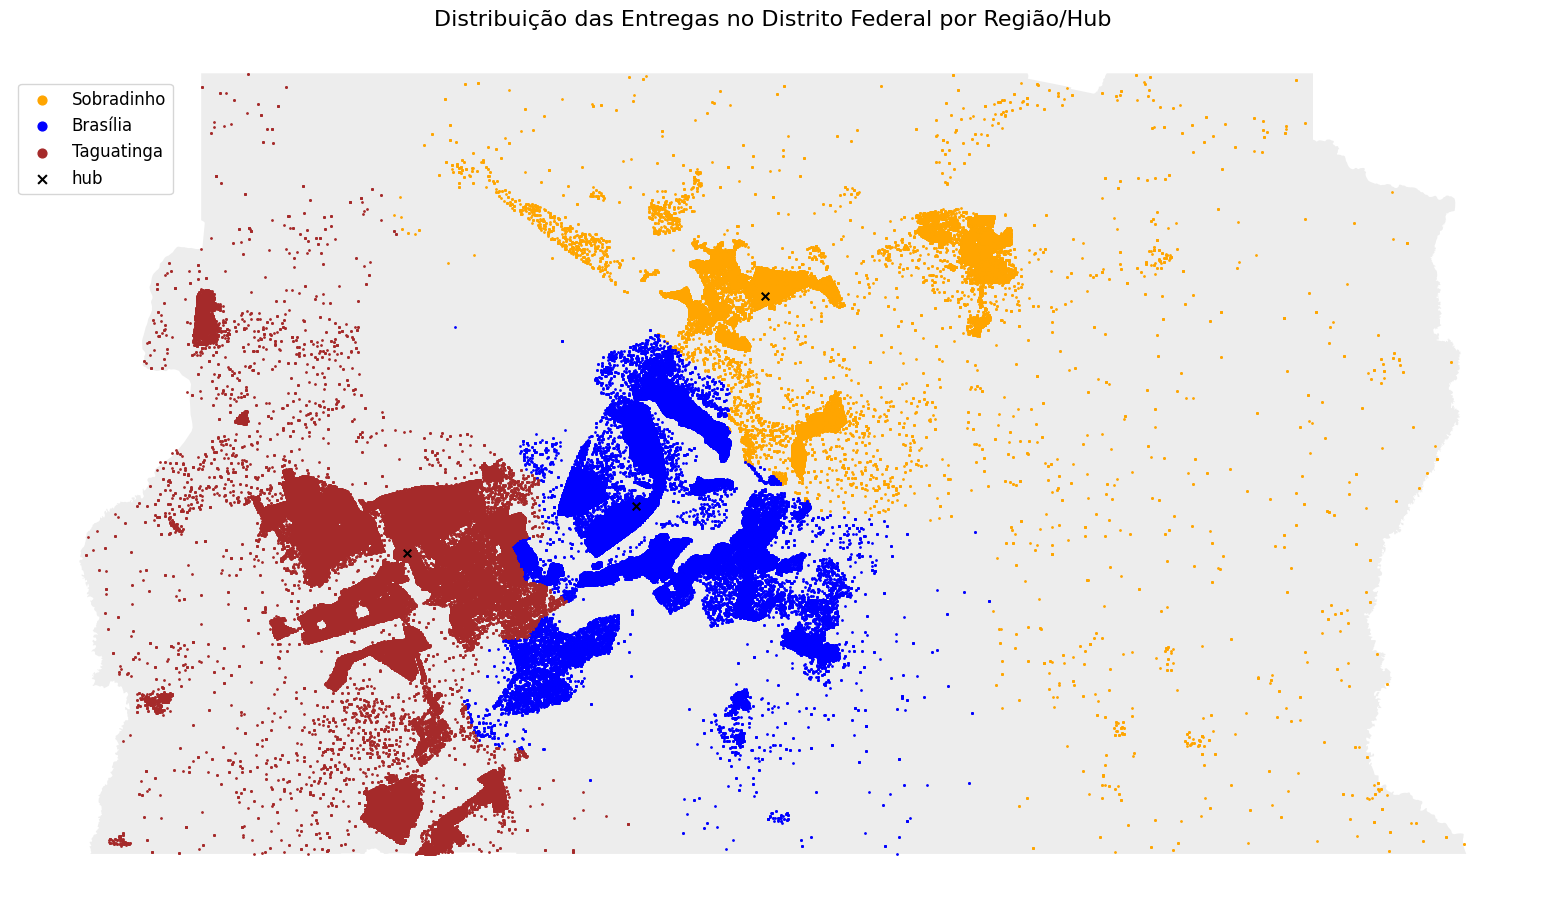

In [ ]:
# Criação do plot vazio.
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# Plot do mapa do Distrito Federal.
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# Plot das entregas por região.
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="orange", label="Sobradinho")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="Brasília")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="brown", label="Taguatinga")

# Plot dos hubs.
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# Plot da legenda.
plt.title("Distribuição das Entregas no Distrito Federal por Região/Hub", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 12}, loc="upper left", bbox_to_anchor=(0., 0.85, 1., .102))
for handle in lgnd.legend_handles:
    handle.set_sizes([40])

# Remover valores dos eixos
ax.set_xticks([])
ax.set_yticks([])

# Remover bordas do mapa
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

**Insights:**

1. Os hubs de distribuição localizam-se próximos das áreas centrais de maior densidade de suas regiões entrega;

2. Os hubs de **Sobradinho** e de **Taguatinga** realizam entregas em locais distantes do centro e entre si, o que pode gerar aumento do tempo  e dos custos de deslocamento.

3. O hub de **Brasília** apresenta uma área mais limitada e com volume concentrado de entregas.

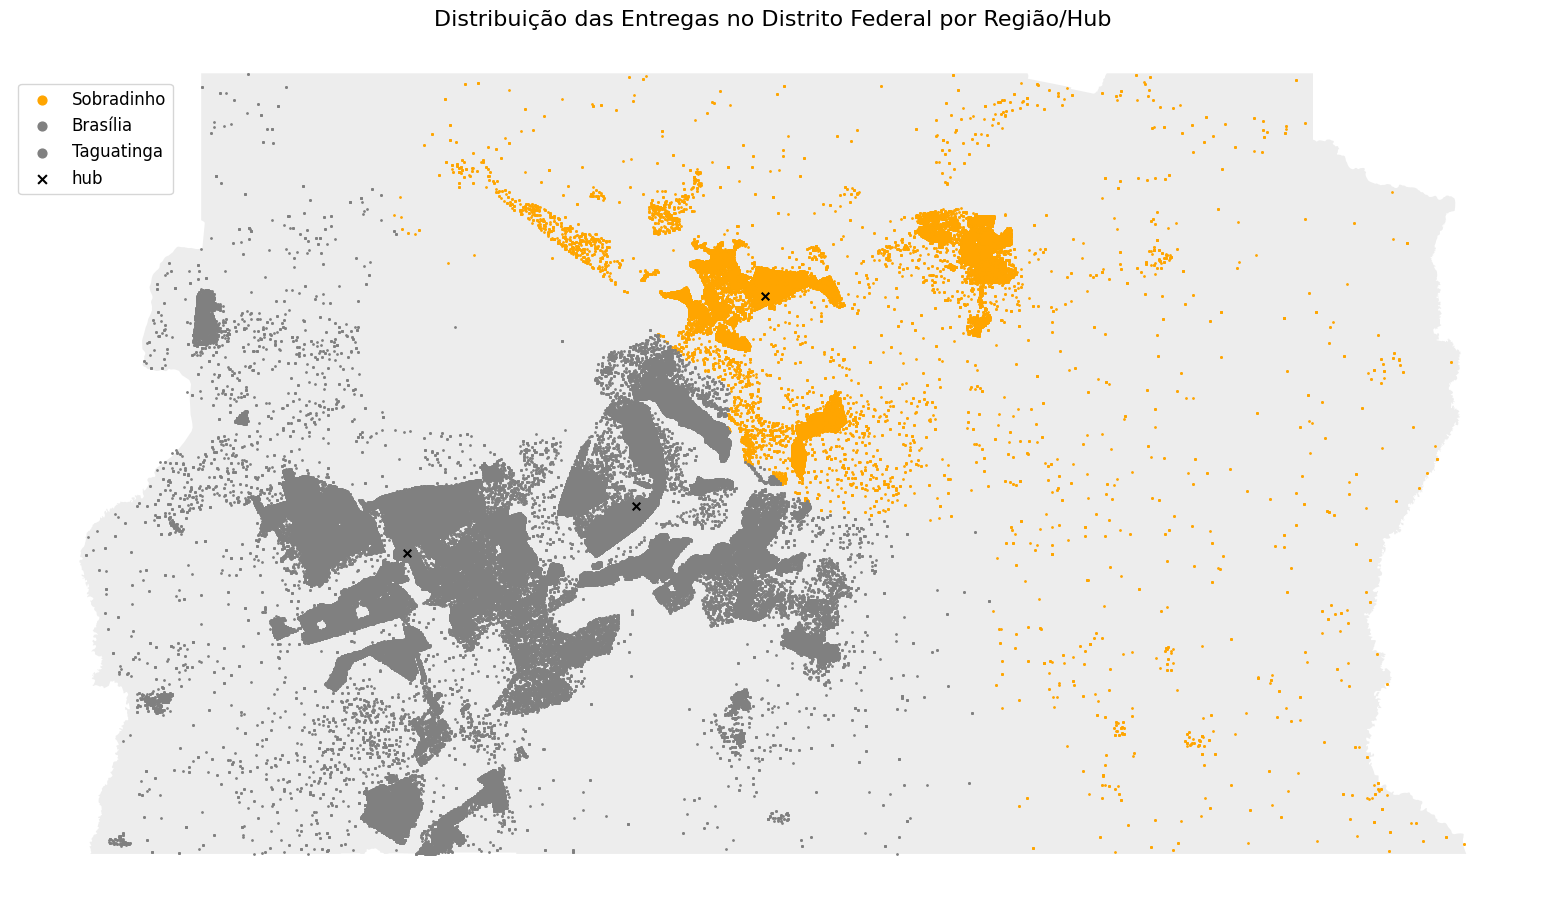

In [ ]:
# Criação do plot vazio.
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# Plot do mapa do Distrito Federal.
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# Plot das entregas por região.
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="orange", label="Sobradinho")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="0.5", label="Brasília")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="0.5", label="Taguatinga")

# Plot dos hubs.
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# Plot da legenda.
plt.title("Distribuição das Entregas no Distrito Federal por Região/Hub", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 12}, loc="upper left", bbox_to_anchor=(0., 0.85, 1., .102))
for handle in lgnd.legend_handles:
    handle.set_sizes([40])


# Remover valores dos eixos
ax.set_xticks([])
ax.set_yticks([])

# Remover bordas do mapa
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

**Insights:**

Nesse mapa, destaca-se o **hub de Sobradinho** e sua área de entrega. Identifica-se duas áreas de concentração de entregas e uma extensa área com entregas dispersas que possuem longas distâncias até o hub.

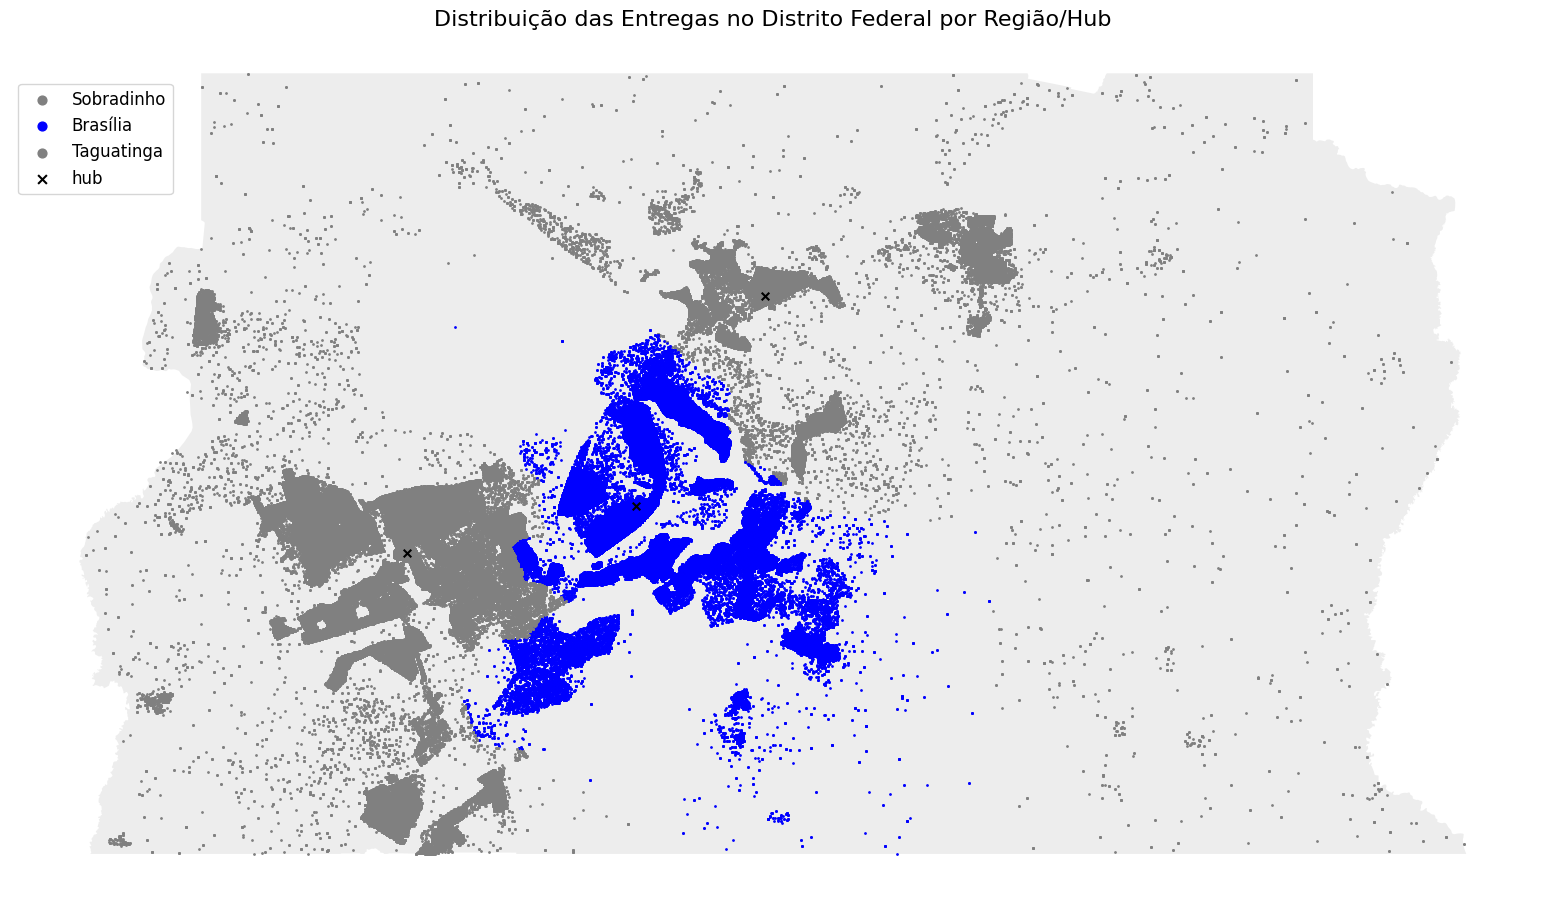

In [ ]:
# Criação do plot vazio.
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# Plot do mapa do Distrito Federal.
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# Plot das entregas por região.
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="0.5", label="Sobradinho")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="Brasília")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="0.5", label="Taguatinga")

# Plot dos hubs.
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# Plot da legenda.
plt.title("Distribuição das Entregas no Distrito Federal por Região/Hub", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 12}, loc="upper left", bbox_to_anchor=(0., 0.85, 1., .102))
for handle in lgnd.legend_handles:
    handle.set_sizes([40])


# Remover valores dos eixos
ax.set_xticks([])
ax.set_yticks([])

# Remover bordas do mapa
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

**Insights:**

Já no mapa do **hub de Brasília** e sua região de entregas, diferencia-se uma região menor e concentrada de entregas com poucas entregas periféricas dispersas próximas do limite com a região do hub de Sobradinho.    

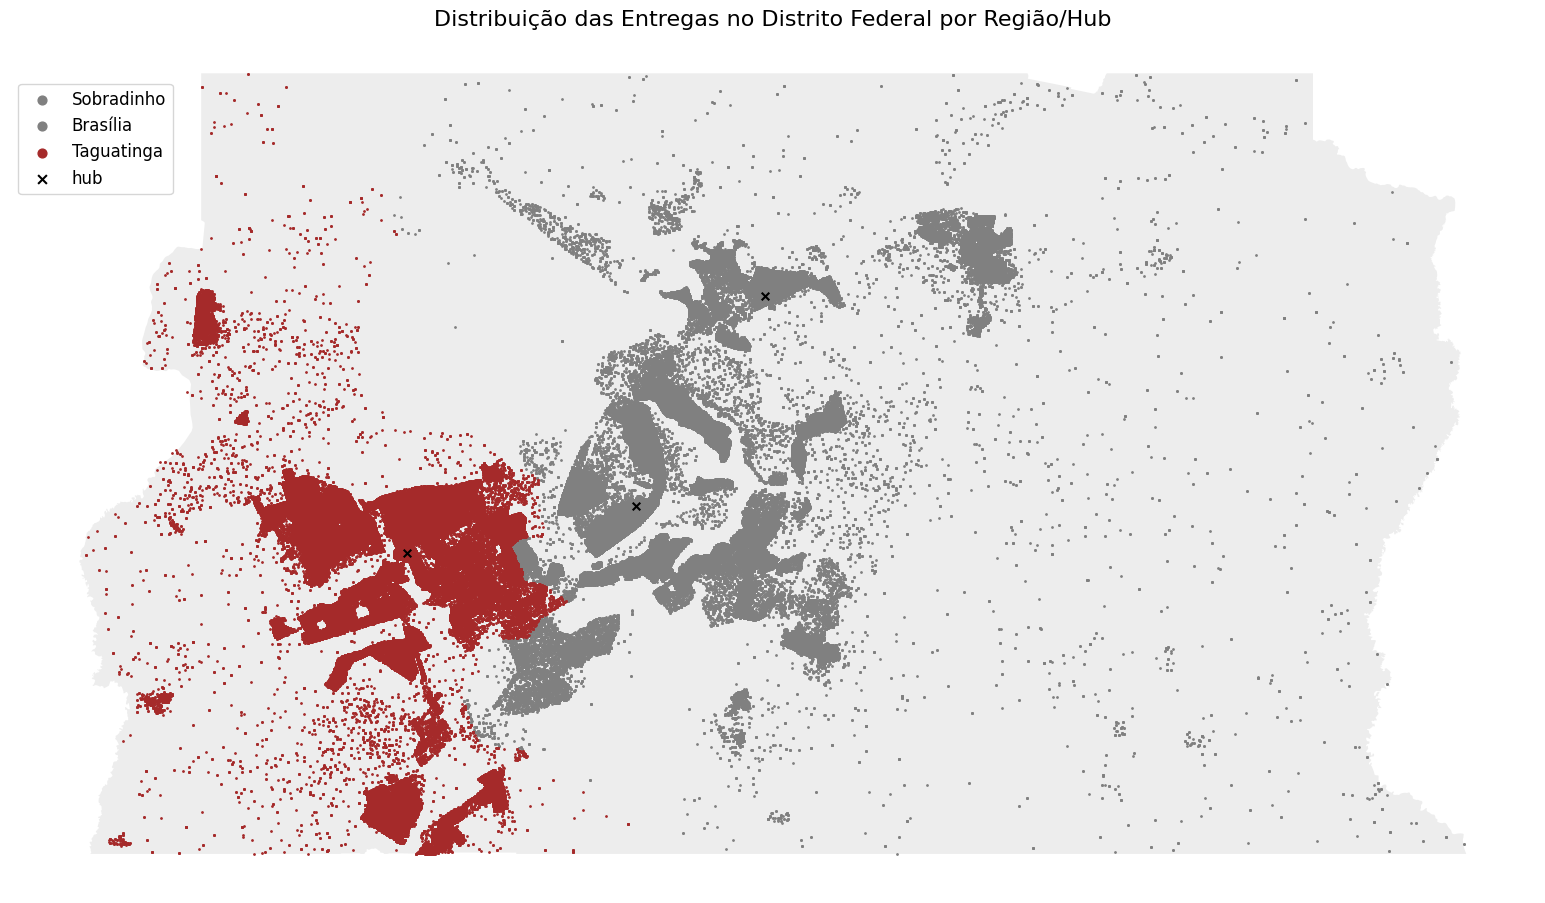

In [ ]:
# Criação do plot vazio.
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# Plot do mapa do Distrito Federal.
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# Plot das entregas por região.
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="0.5", label="Sobradinho")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="0.5", label="Brasília")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="brown", label="Taguatinga")

# Plot dos hubs.
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# Plot da legenda.
plt.title("Distribuição das Entregas no Distrito Federal por Região/Hub", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 12}, loc="upper left", bbox_to_anchor=(0., 0.85, 1., .102))
for handle in lgnd.legend_handles:
    handle.set_sizes([40])


# Remover valores dos eixos
ax.set_xticks([])
ax.set_yticks([])

# Remover bordas do mapa
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

**Insights:**

Por fim, o mapa do **hub de Taguatinga** e sua região de entrega apresenta várias áreas fragmentadas de concentração de entregas, ao mesmo tempo que possui uma extensa área de poucas e dispersas entregas, da mesma forma que ocorre na região de Sobradinho.

### 4.2.2 Gráfico de Entregas por Região

In [ ]:
# Obtenção das colunas de interesse.

data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()


In [ ]:
# Visualização tabular.

data = data.rename(columns={"proportion": "region_percent"})
data.head()

,region,vehicle_capacity,region_percent
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


**Insights:**

Quanto às **entregas**:


1) O hub de **Brasília (df-1)** realiza em torno de **48%** das entregas feitas no Distrito Federal;

2) Já o hub de **Taguatinga(df-2)**, perfaz ao redor de **41%** das entregas no Distrito Federal;

3)Por sua vez, o hub de **Sobradinho (df-0)**, totaliza por volta de **11%** das entregas no Distrito Federal.

Quanto à **capacidade** de transporte dos veículos:

A capacidade de volume de transporte dos veículos é **igual** para os três hubs.

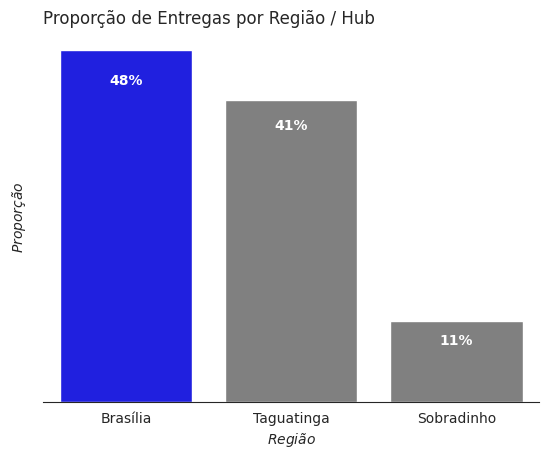

In [ ]:
# Gráfico com maior porcentual de entrega em destaque

#Lista com nome da região dos hubs.
regiao_nomes = ['Brasília', 'Taguatinga', 'Sobradinho']

#Estrutura de cores
with sns.axes_style('white'):
    colors = ['blue'] + ['gray'] * (len(data['region']) - 1)  ##Maior valor em destaque

#Plot do Gráfico
grafico = sns.barplot(data=data, x="region", y="region_percent", hue= 'region', palette=colors, errorbar=None)

#Remoção de bordas
grafico.spines['top'].set_visible(False)
grafico.spines['right'].set_visible(False)
grafico.spines['left'].set_visible(False)
grafico.spines['bottom'].set_visible(True)

#Remoção de rótulos do eixo y
grafico.set(ylabel=None)
grafico.set(yticklabels=[])

#Ajuste do título do gráfico à esquerda
grafico.set_title('Proporção de Entregas por Região / Hub', loc='left')

#Formatar os títulos dos eixos para itálico
grafico.set_xlabel('$\it{Região}$', fontsize=10)
grafico.set_ylabel('$\it{Proporção}$', fontsize=10)

#Exibir e transformar valores dos rótulos de dados em porcentagem e exibir dentro das margens das barras
for i, p in enumerate(grafico.patches):
    height = p.get_height()
    percentage = f'{height:.0%}'      ##Formatar como porcentagem sem casa decimal
    x = p.get_x() + p.get_width() / 2
    y = height * 0.9                  ## Posição padrão

#Ajustar a posição vertical do rótulo de dados da terceira barra (índice 2)
if i == 2:
    y = height * 0.7  ## Move mais para baixo

#Formatação do texto do gráfico
grafico.text(x, y, percentage, ha='center', color='white', weight='bold', fontsize=10)

#Substituir os nomes das colunas para os nomes do hubs
num_regioes = len(regiao_nomes)
grafico.set_xticks(np.arange(num_regioes))
grafico.set_xticklabels(regiao_nomes)

#Exibir gráfico
plt.show()

**Insights:**

Destaca-se o hub de Brasília pela maior parte das entregas no Distrito Federal. Além disso, possui uma região de entrega menor em relação aos outros hubs, o que indica ser uma região mais densamente povoada e, portanto, com mais potencial de pedidos.    

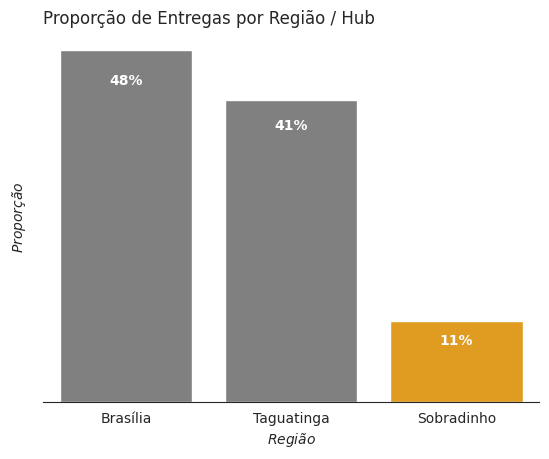

In [ ]:
# Gráfico com menor porcentual de entrega em destaque

#lista com nome das regiões dos hubs
regiao_nomes = ['Brasília', 'Taguatinga', 'Sobradinho']

#Estrutura de cores
with sns.axes_style('white'):
    colors = ['gray'] * (len(data['region']) - 1) + ['orange']  ##Menor valor em destaque

#Plotagem do gráfico
    grafico = sns.barplot(data=data, x="region", y="region_percent", hue= 'region', palette=colors, errorbar=None)

#Remoção de bordas
grafico.spines['top'].set_visible(False)
grafico.spines['right'].set_visible(False)
grafico.spines['left'].set_visible(False)
grafico.spines['bottom'].set_visible(True)

#Remoção de rótulos do eixo y
grafico.set(ylabel=None)
grafico.set(yticklabels=[])

#Ajuste do título do gráfico à esquerda
grafico.set_title('Proporção de Entregas por Região / Hub', loc='left')

#Formatar títulos dos eixos para itálico
grafico.set_xlabel('$\it{Região}$', fontsize=10)
grafico.set_ylabel('$\it{Proporção}$', fontsize=10)

#Exibir e transformar valores dos rótulos de dados em porcentagem e exibir dentro das barras
for i, p in enumerate(grafico.patches):
    height = p.get_height()
    percentage = f'{height:.0%}'        ## Formatar como porcentagem sem casa decimal
    x = p.get_x() + p.get_width() / 2
    y = height * 0.9                    ## Posição padrão

#Ajustar a posição vertical do rótulo de dados da terceira barra (índice 2)
if i == 2:
    y = height * 0.7  ## Move mais para baixo

#Formatação do texto do gráfico
grafico.text(x, y, percentage, ha='center', color='white', weight='bold', fontsize=10)

#Substituir os nomes das colunas
num_regioes = len(regiao_nomes)
grafico.set_xticks(np.arange(num_regioes))
grafico.set_xticklabels(regiao_nomes)

#Exibição do gráfico
plt.show()

**Insights:**

Aqui se sobressai a situação do hub de Sobradinho que atende o menor porcentual de pedidos de entrega, embora sua área seja maior que as outras. Ainda, os pedidos dessa área se caracterizam por estarem distantes e dispersos pela região.

# 5. CONCLUSÃO

Os insights importantes a serem considerados pelos gestores em sua *tomada de decisão* são:

1. Os hubs de Brasília e de Taguatinga concentram o maior percentual de entregas. Entretanto, desses dois hubs, o hub de Taguatinga apresenta maior dispersão das áreas de entrega e as maiores distâncias entre as entregas e o hub.

2. Já o hub de Sobradinho concentra o menor percentual de entregas e possui mais áreas de entrega distantes do que a região de Taguatinga.

3. Em relação à capacidade de transporte dos veículos, que é a mesma para todos, o hub de Sobradinho poderia dispôr também em sua frota de uma parcela de veículos com capacidade menor de transporte, o que pode contribuir na redução de custos de combustível e de manutenção.

4. O hub de Taguatinga também poderia ter veículos com capacidade de transporte menores a compor sua frota para atender os pedidos de entrega distantes.  

5. Uma outra possibilidade que pode ser avaliada é realocar algumas áreas de entrega entre os hubs de Sobradinho e de Brasília. Tendo em vista que há áreas próximas e com distâncias muito semelhantes entre os dois hubs, a área sul de grande dispersção do hub de Sobradinho poderia ser atendida pelo hub da região Brasília. Já as áreas norte e nordeste do hub de Brasília, poderiam ser atendidas pelo hub de Sobradinho. Essa abordagem alternativa poderia otimizar a distribuição da quantidade de entregas, do uso e do custo dos veículos de entrega.
